In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import slsim
from slsim.lens_pop import LensPop
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from tqdm import tqdm

In [2]:
path = os.path.dirname(slsim.__file__)
module_path, _ = os.path.split(path)
skypy_config = os.path.join(module_path, "data/SkyPy/roman-like.yml")

configure_roman_filters()

roman_filters = filter_names()

_ = speclite.filters.load_filters(
    roman_filters[0],
    roman_filters[1],
    roman_filters[2],
    roman_filters[3],
    roman_filters[4],
    roman_filters[5],
    roman_filters[6],
    roman_filters[7],
)

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

sky_area = Quantity(value=5., unit="deg2")

Place stricter magnitude cuts on the second `LensPop`

In [4]:
kwargs_deflector_cut_1 = {"band": "F062", "band_max": 25, "z_min": 0.01, "z_max": 3.0}
kwargs_source_cut_1 = {"band": "F062", "band_max": 28, "z_min": 0.01, "z_max": 5.0}

lens_pop_1 = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut_1,
    kwargs_source_cut=kwargs_source_cut_1,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [5]:
kwargs_deflector_cut_2 = {"band": "F062", "band_max": 22, "z_min": 0.01, "z_max": 3.0}
kwargs_source_cut_2 = {"band": "F062", "band_max": 23, "z_min": 0.01, "z_max": 5.0}

lens_pop_2 = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut_2,
    kwargs_source_cut=kwargs_source_cut_2,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [6]:
kwargs_lens_cut = {
    "min_image_separation": 0.2,
    "max_image_separation": 10,
    "mag_arc_limit": {"F158": 25, "F106": 25, "F062": 25},
}

lens_population_1 = lens_pop_1.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

print("Number of lenses:", len(lens_population_1))

Number of lenses: 57257


In [7]:
lens_population_2 = lens_pop_2.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

print("Number of lenses:", len(lens_population_2))

Number of lenses: 431


So far, this makes sense: there are fewer systems in the second population with stricter filters on magnitudes.

Define some methods to estimate SNR of lensed source in F106

In [8]:
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.Util import data_util, util


def get_snr(gglens, band):
    total_image, lens_surface_brightness, source_surface_brightness = get_image(gglens, band)

    # calculate region for source surface brightness array and count signal
    stdev = np.std(source_surface_brightness)
    mean = np.mean(source_surface_brightness)
    mask = source_surface_brightness < mean + (1 * stdev)
    masked_source = np.ma.masked_array(source_surface_brightness, mask=mask)
    sum_source_counts = np.sum(masked_source)

    # estimate and add background
    min_zodiacal_light_f106 = 0.29
    thermal_background_f106 = 0
    estimated_background = (min_zodiacal_light_f106 * 1.5) + thermal_background_f106  # in counts/pixel
    estimated_background *= np.ones(total_image.shape)
    total_image += estimated_background

    # estimated total noise in 180s from https://roman.gsfc.nasa.gov/science/WFI_technical.html
    noise_180s = 5.5  # e- RMS
    noise_rms = noise_180s * (146 / 180)
    noise_array = np.random.poisson(noise_rms, total_image.shape)
    total_image += noise_array

    # count total signal
    masked_total = np.ma.masked_array(total_image, mask=mask)
    sum_total_counts = np.sum(masked_total)

    # calculate estimated SNR
    return sum_source_counts / np.sqrt(sum_total_counts), total_image


def get_image(gglens, band):
    kwargs_model, kwargs_params = gglens.lenstronomy_kwargs(band=band)

    magnitude_zero_point = Roman.F106_band_obs['magnitude_zero_point']
    lens_model = LensModel(kwargs_model['lens_model_list'])
    source_light_model = LightModel(kwargs_model['source_light_model_list'])
    lens_light_model = LightModel(kwargs_model['lens_light_model_list'])
    kwargs_lens = kwargs_params['kwargs_lens']
    kwargs_source = kwargs_params['kwargs_source']
    kwargs_lens_light = kwargs_params['kwargs_lens_light']
    kwargs_source_amp = data_util.magnitude2amplitude(source_light_model, kwargs_source, magnitude_zero_point)
    kwargs_lens_light_amp = data_util.magnitude2amplitude(lens_light_model, kwargs_lens_light, magnitude_zero_point)

    # set up image
    num_pix = 45  # at 0.11 pixels/", 10.01"
    psf_class = PSF(**{'psf_type': 'GAUSSIAN', 'fwhm': 0.087})
    kwargs_numerics = {
        'supersampling_factor': 1,
        'supersampling_convolution': False
    }
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, Mcoord2pix = util.make_grid_with_coordtransform(
        numPix=num_pix,
        deltapix=0.11,
        subgrid_res=1,
        left_lower=False,
        inverse=False)
    kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0,
                    'transform_pix2angle': Mpix2coord}
    pixel_grid = PixelGrid(**kwargs_pixel)
    image_model = ImageModel(data_class=pixel_grid,
                             psf_class=psf_class,
                             lens_model_class=lens_model,
                             source_model_class=source_light_model,
                             lens_light_model_class=lens_light_model,
                             kwargs_numerics=kwargs_numerics)

    # get surface brightness arrays
    lens_surface_brightness = image_model.lens_surface_brightness(kwargs_lens_light_amp)
    source_surface_brightness = image_model.source_surface_brightness(kwargs_source_amp, kwargs_lens)
    total_image = image_model.image(kwargs_lens=kwargs_lens,
                                    kwargs_source=kwargs_source_amp,
                                    kwargs_lens_light=kwargs_lens_light_amp)

    return total_image, lens_surface_brightness, source_surface_brightness

In [9]:
detectable_gglenses_1, snr_1 = [], []
for candidate in tqdm(lens_population_1):
    # 1. Einstein radius and Sersic radius
    _, kwargs_params = candidate.lenstronomy_kwargs(band='F106')
    lens_mag = candidate.deflector_magnitude(band='F106')

    if kwargs_params['kwargs_lens'][0]['theta_E'] < kwargs_params['kwargs_lens_light'][0][
        'R_sersic'] and lens_mag < 15:
        continue

    # 2. SNR
    snr, _ = get_snr(candidate, 'F106')
    snr_1.append(snr)

    if snr < 10:
        continue

    # if both criteria satisfied, consider detectable
    detectable_gglenses_1.append(candidate)

 21%|██        | 11991/57257 [00:27<01:39, 456.39it/s]

100%|██████████| 57257/57257 [02:08<00:00, 446.11it/s]


In [10]:
detectable_gglenses_2, snr_2 = [], []
for candidate in tqdm(lens_population_2):
    # 1. Einstein radius and Sersic radius
    _, kwargs_params = candidate.lenstronomy_kwargs(band='F106')
    lens_mag = candidate.deflector_magnitude(band='F106')

    if kwargs_params['kwargs_lens'][0]['theta_E'] < kwargs_params['kwargs_lens_light'][0][
        'R_sersic'] and lens_mag < 15:
        continue

    # 2. SNR
    snr, _ = get_snr(candidate, 'F106')
    snr_2.append(snr)

    if snr < 10:
        continue

    # if both criteria satisfied, consider detectable
    detectable_gglenses_2.append(candidate)

 73%|███████▎  | 313/431 [00:00<00:00, 450.71it/s]

100%|██████████| 431/431 [00:00<00:00, 438.54it/s]


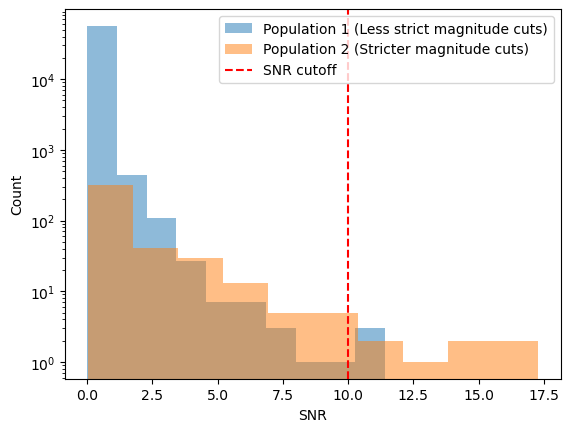

In [11]:
plt.hist(snr_1, label='Population 1 (Less strict magnitude cuts)', alpha=0.5)
plt.hist(snr_2, label='Population 2 (Stricter magnitude cuts)', alpha=0.5)
plt.xlabel('SNR')
plt.ylabel('Count')
plt.yscale('log')
plt.axvline(10, color='r', linestyle='--', label='SNR cutoff')
plt.legend()
plt.show()

In [12]:
print(f'Number of detectable lenses in the population 1: {len(detectable_gglenses_1)}')
print(f'Percentage detectable in population 1: {len(detectable_gglenses_1) / len(lens_population_1) * 100:.2f}%')

Number of detectable lenses in the population 1: 4
Percentage detectable in population 1: 0.01%


In [13]:
print(f'Number of detectable lenses in population 2: {len(detectable_gglenses_2)}')
print(f'Percentage detectable in population 2: {len(detectable_gglenses_2) / len(lens_population_2) * 100:.2f}%')

Number of detectable lenses in population 2: 7
Percentage detectable in population 2: 1.62%
